# Community detection

## Utils

In [ ]:
!pip install python-louvain
!pip install scikit-network

In [ ]:
import networkx as nx
from networkx import edge_betweenness_centrality as betweenness
from networkx.algorithms import community
from community import community_louvain
from sknetwork.hierarchy import Paris, cut_straight, dasgupta_score, tree_sampling_divergence
from sknetwork.visualization import svg_graph, svg_dendrogram
from sknetwork.hierarchy.postprocess import cut_straight

import pandas as pd
import numpy as np
import itertools
from operator import itemgetter
import re


from google.colab import files
from IPython.display import SVG
import matplotlib.pyplot as plt

In [ ]:
def network_from_edges(edges):
  dict_edges = {}
  for ind in range(len(edges)):
    if edges.iloc[ind,2] > 10:
      dict_edges[(edges.iloc[ind,0], edges.iloc[ind,1])] = edges.iloc[ind,2]
  net = pd.DataFrame.from_dict(dict_edges,orient='index')
  net.columns = ["weight"]
  net.sort_values(by="weight",inplace=True, ascending=False)
  return dict_edges, net


def get_graph(network):
  G = nx.Graph()
  for edge in network:
      #we can filter edges by weight by uncommenting the next line and setting desired weight threshold
      G.add_edge(edge[0], edge[1], weight=network[edge])
  
  #G.add_weighted_edges_from(up_weighted, weight='weight')
  return G


def extract_text(df):       #extract the text from the tweets and RT
                            #works ONLY on .csv file
  list_strings = []
  for index in range(len(df)):
    text = df.loc[index]['text']                          #if it is nor trucated nor a RT  i take "text"
    string = -1
    if (df.loc[index,"truncated"] == True):                 #if it is trucated I take "extended_tweet"
        string = df.loc[index,"extended_tweet"]
    if type(df.loc[index,"retweeted_status"]) != float:     #if it is a RT I take retweeted_status
        string = df.loc[index,"retweeted_status"]
    if type(string) == str :
        if(re.search('full_text\':(.+?)https',string) != None):     #if I find "full_text"
          s = re.search('full_text\':(.+?)https',string).group(1)
        if(re.search('text\':(.+?)https',string)!= None):
          s = re.search('text\':(.+?)https',string).group(1)
        else: 
          continue
        list_strings.append(s)
    else:
      list_strings.append(text)

  return list_strings


def frequency_dictionary(df):
  unique_words = {}

  for row in df:
    for word in row.split():
      #if the word is encountered for the first time add to dict as key and set its value to 0
      unique_words.setdefault(word,0)
      #increase the value (i.e the count) of the word by 1 every time it is encountered
      unique_words[word] += 1

  return unique_words


def adj_matrix(node_list, edge_list):   

  words = sorted(list(node_list['Id']))

  A = pd.DataFrame(np.zeros((len(words),len(words))), columns = words, index = words)
  print('A shape: ', A.shape)
  for row in range(len(edge_list)):
    if row%1000==0:
      print(str(round(row/1000)) + '/' + str(round(len(edge_list)/1000)))
    word1 = edge_list.iloc[row, 0]
    word2 = edge_list.iloc[row, 1]
    weight = edge_list.iloc[row, 2]
    A[word1, word2] = weight
    A[word2, word1] = weight
  print('A shape: ', A.shape)
  return A

In [ ]:
def community_check(community, dict_1, dict_2, G_1, G_2, thr):
  sum_1 = 0
  sum_2 = 0
  sum_12 = 0
  for key in community:
    if (key in list(dict_1.keys())) and (key in list(dict_2.keys())):
      if dict_1[key] / sum(list(dict_1.values())) - dict_2[key] / sum(list(dict_2.values())) > thr:
        sum_1 += 1
      elif dict_1[key] / sum(list(dict_1.values())) - dict_2[key] / sum(list(dict_2.values())) < -thr:
        sum_2 += 1  
      else:
        sum_12 += 1 
    elif key in list(G_1.nodes()):
      sum_1 += 1
    elif key in list(G_2.nodes()):
      sum_2 += 1
  return sum_1, sum_2, sum_12

In [ ]:
# Functions for measuring the quality of a partition (into communities).

def compute_metrics(G, partition):

  # Returns the coverage of a partition.
  coverage = community.coverage(G, partition)

  # Returns the coverage and performance of a partition of G.
  quality = community.partition_quality(G, partition)

  performance = community.performance(G, partition)

  # Returns the modularity of the given partition of the graph.
  modularity = community.modularity(G, partition)

  print("Coverage: ", coverage)
  # print("Quality: ", quality) # Coverage and performance
  print("Performance: ", performance)
  print("Modularity: ", modularity)

  return coverage, quality, performance, modularity


In [ ]:
def community_layout(g, partition):
    """
    Compute the layout for a modular graph.


    Arguments:
    ----------
    g -- networkx.Graph or networkx.DiGraph instance
        graph to plot

    partition -- dict mapping int node -> int community
        graph partitions


    Returns:
    --------
    pos -- dict mapping int node -> (float x, float y)
        node positions

    """

    pos_communities = _position_communities(g, partition, scale=2.)

    pos_nodes = _position_nodes(g, partition, scale=2.)

    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]

    return pos

def _position_communities(g, partition, **kwargs):

    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = nx.circular_layout(hypergraph, **kwargs)

    # set node positions to position of community
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos

def _find_between_community_edges(g, partition):

    edges = dict()

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges

def _position_nodes(g, partition, **kwargs):
    """
    Positions nodes within communities.
    """

    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)

    return pos

# PageRank Networks

## **All periods**

### Download data

In [ ]:
China = pd.read_csv('/content/China.csv')
USA = pd.read_csv('/content/USA.csv',)

edges = pd.read_csv('/content/edgelist_China_USA.csv')
edges_China = pd.read_csv('/content/edgelist_China.csv')
edges_USA = pd.read_csv('/content/edgelist_USA.csv')

nodes = pd.read_csv('/content/nodelist_China_USA.csv')

text_China = extract_text(China)
text_USA = extract_text(USA)

freq_dict_China = frequency_dictionary(text_China)
freq_dict_China = dict(sorted(freq_dict_China.items(), key=lambda item: item[1], reverse = True))   #order from more frequent to less frequent word

freq_dict_USA = frequency_dictionary(text_USA)
freq_dict_USA = dict(sorted(freq_dict_USA.items(), key=lambda item: item[1], reverse = True))   #order from more frequent to less frequent word

net, net_df = network_from_edges(edges)
net_China, _ = network_from_edges(edges_China)
net_USA, _ = network_from_edges(edges_USA)
G = get_graph(net)
G_China = get_graph(net_China)
G_USA = get_graph(net_USA)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (34,35,38) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
print('China&USA:')
print('Nodes: ',len(G.nodes()))
print('Edges: ',len(G.edges()))
print('Is connected: ',nx.is_connected(G))
print()
print('China:')
print('Words: ',len(freq_dict_China))
print()
print('USA:')
print('Words: ',len(freq_dict_USA))

China&USA:
Nodes:  509
Edges:  11982
Is connected:  True

China:
Words:  16883

USA:
Words:  39094


### Bipartition
Partition a graph into two blocks using the Kernighan–Lin algorithm.

In [ ]:
community_bipart = community.kernighan_lin_bisection(G,weight='weight')

In [ ]:
print(community_bipart[0])
print(community_bipart[1])

{'medium', 'crisis', 'read', 'major', 'human', 'evacuate', 'agency', 'korea', 'ban', 'mike', 'suspend', 'drop', 'urge', 'post', 'free', 'ahead', 'seek', 'research', 'within', 'secretary', 'without', 'push', 'visit', 'committee', 'track', 'industry', 'italy', 'challenge', 'special', 'batch', 'right', 'mark', 'california', 'move', 'already', 'group', 'breaking', 'life', 'critical', 'hard', 'growth', 'catch', 'try', 'delay', 'billion', 'school', 'street', 'force', 'want', 'student', 'win', 'nominee', 'former', 'relief', 'several', 'combat', 'talk', 'small', 'pneumonia', 'democratic', 'affect', 'diagnosis', 'reopen', 'court', 'seven', 'bank', 'today', 'slow', 'confidence', 'order', 'link', 'adviser', 'worry', 'great', 'donate', 'benefit', 'likely', 'debate', 'stand', 'federal', 'governor', 'boost', 'diagnose', 'potential', 'avoid', 'yet', 'build', 'turn', 'issue', 'decline', 'almost', 'penny', 'condition', 'scientist', 'break', 'war', 'express', 'base', 'employee', 'young', 'north', 'share

In [ ]:
threshold = 0.00001
sum_China_0, sum_USA_0, sum_China_USA_0 = community_check(community_bipart[0], freq_dict_China, freq_dict_USA, G_China, G_USA, threshold)
sum_China_1, sum_USA_1, sum_China_USA_1 = community_check(community_bipart[1], freq_dict_China, freq_dict_USA, G_China, G_USA, threshold)

In [ ]:
print('First community:')
print('China: ', round(100 * sum_China_0 / len(community_bipart[0])),'%')
print('USA: ', round(100 * sum_USA_0 / len(community_bipart[0])),'%')
print('China&USA: ', round(100 * sum_China_USA_0 / len(community_bipart[0])),'%')
print()
print('China: ', round(100 * sum_China_1 / len(community_bipart[1])),'%')
print('USA: ', round(100 * sum_USA_1 / len(community_bipart[1])),'%')
print('China&USA: ', round(100 * sum_China_USA_1 / len(community_bipart[1])),'%')

First community:
China:  28 %
USA:  63 %
China&USA:  10 %

China:  39 %
USA:  53 %
China&USA:  7 %


**Metrics**

In [ ]:
_ = compute_metrics(G, community_bipart)

Coverage:  0.6877816725087631
Performance:  0.5357888711848151
Modularity:  -0.0052737937584390136


### Modularity-based communities
Find communities in G using greedy modularity maximization.

In [ ]:
community_mod = community.greedy_modularity_communities(G, n_communities=2, weight='weight')
# communities_naive_mod = community.naive_greedy_modularity_communities(G)

In [ ]:
community_mod_list = []
for comm in community_mod:
 print(list(comm))
 community_mod_list.append(list(comm))

['measure', 'prevention', 'government', 'cause', 'china', 'live', 'people', 'pandemic', 'economy', 'restaurant', 'novel', 'human', 'street', 'lead', 'prevent', 'market', 'crisis', 'year', 'family', 'affect', 'department', 'contain', 'global', 'declare', 'coronavirus', 'care', 'community', 'step', 'passenger', 'outside', 'japan', 'beijing', 'combat', 'send', 'epicenter', 'battle', 'cancel', 'update', 'epidemic', 'demand', 'special', 'central', 'service', 'fight', 'spread', 'visit', 'business', 'effort', 'work', 'force', 'social', 'resident', 'express', 'full', 'major', 'die', 'late', 'man', 'almost', 'evacuate', 'flight', 'place', 'foreign', 'look', 'continue', 'break', 'around', 'cruise', 'take', 'support', 'read', 'treatment', 'stop', 'city', 'deadly', 'win', 'raise', 'join', 'much', 'hospital', 'employee', 'bank', 'stand', 'order', 'keep', 'outbreak', 'hand', 'build', 'like', 'center', 'challenge', 'infect', 'already', 'growth', 'asian', 'curb', 'old', 'change', 'travel', 'citizen', 

In [ ]:
threshold = 0.00001
for i in range(len(community_mod_list)):
  sum_China, sum_USA, sum_China_USA = community_check(community_mod_list[i], freq_dict_China, freq_dict_USA, G_China, G_USA, threshold)
  print('Community: ', i)
  print('China: ', round(100 * sum_China / len(community_mod_list[i])),'%')
  print('USA: ', round(100 * sum_USA / len(community_mod_list[i])),'%')
  print('China&USA: ', round(100 * sum_China_USA / len(community_mod_list[i])),'%')
  print()

Community:  0
China:  44 %
USA:  48 %
China&USA:  9 %

Community:  1
China:  22 %
USA:  68 %
China&USA:  11 %

Community:  2
China:  23 %
USA:  70 %
China&USA:  7 %

Community:  3
China:  46 %
USA:  46 %
China&USA:  7 %

Community:  4
China:  50 %
USA:  25 %
China&USA:  25 %



**Metrics**

In [ ]:
_ = compute_metrics(G, community_mod_list)

Coverage:  0.3890836254381572
Performance:  0.718051451819996
Modularity:  0.1837115988393901


In [ ]:
colors = list(G.nodes)
i = 0
dict_nodes = {}
for node in colors:
  if node in community_mod_list[0]:
    colors[i] = 'violet'
    dict_nodes[node] = 0
  if node in community_mod_list[1]:
    colors[i] = 'lightcoral'
    dict_nodes[node] = 1
  if node in community_mod_list[2]:
    colors[i] = 'lawngreen'
    dict_nodes[node] = 2
  if node in community_mod_list[3]:
    colors[i] = 'cyan'
    dict_nodes[node] = 3
  if node in community_mod_list[4]:
    colors[i] = 'dodgerblue'
    dict_nodes[node] = 4
  i += 1

In [ ]:
pos = community_layout(G, dict_nodes)
fig = plt.figure(1, figsize=(200, 80), dpi=60)
nx.draw_networkx(G, pos, node_color=colors, node_size=5000, with_labels=True,
                 font_size =50,width=0.05)
plt.show()

### Louvain Community Detection
Find the best partition of a graph using the Louvain Community Detection Algorithm.

In [ ]:
# communities_louvain = community.louvain.louvain_communities(G)
# partitions_louvain = community.louvain.louvain_partitions(G)

community_louv = community_louvain.best_partition(G,weight='weight')

# modularity_louvain = community.modularity(communities_louvain, G) # ERROR: not a partition
# print("The modularity Q based on networkx is {}".format(modularity_louvain))

In [ ]:
max = np.max(list(community_louv.values()))
community_louvain_list = []
for i in range(max+1):
  community_louvain_list.append([])
for key in list(community_louv.keys()):
  community_louvain_list[community_louv[key]].append(key)
for i in range(max+1):
  print(community_louvain_list[i])

['talk', 'president', 'trump', 'say', 'relief', 'house', 'aid', 'secretary', 'first', 'test', 'positive', 'person', 'announce', 'team', 'office', 'chief', 'critical', 'condition', 'official', 'hold', 'week', 'come', 'diagnose', 'leader', 'also', 'press', 'put', 'former', 'ask', 'doctor', 'symptom', 'top', 'recovery', 'video', 'general', 'director', 'tell', 'vice', 'good', 'would', 'still', 'return', 'quarantine', 'add', 'within', 'staff', 'source', 'military', 'experience', 'release', 'remain', 'senior', 'statement', 'analysis', 'claim', 'administration', 'campaign', 'white', 'election', 'contact', 'negative', 'hope', 'contract', 'turn', 'several', 'today', 'fauci', 'mark', 'without', 'think', 'diagnosis', 'next', 'lady', 'presidential', 'rally', 'less', 'debate', 'event', 'vote', 'night', 'mike', 'adviser', 'penny', 'joe', 'court', 'nominee', 'republican', 'well', 'democratic', 'breaking', 'member', 'ahead', 'game', 'bill', 'small', 'poll', 'whether']
['china', 'coronavirus', 'novel',

In [ ]:
threshold = 0.00001
for i in range(len(community_louvain_list)):
  sum_China, sum_USA, sum_China_USA = community_check(community_louvain_list[i], freq_dict_China, freq_dict_USA, G_China, G_USA, threshold)
  print('Community: ', i)
  print('China: ', round(100 * sum_China / len(community_louvain_list[i])),'%')
  print('USA: ', round(100 * sum_USA / len(community_louvain_list[i])),'%')
  print('China&USA: ', round(100 * sum_China_USA / len(community_louvain_list[i])),'%')
  print()

Community:  0
China:  27 %
USA:  68 %
China&USA:  5 %

Community:  1
China:  90 %
USA:  10 %
China&USA:  0 %

Community:  2
China:  27 %
USA:  65 %
China&USA:  7 %

Community:  3
China:  38 %
USA:  53 %
China&USA:  9 %

Community:  4
China:  50 %
USA:  45 %
China&USA:  5 %

Community:  5
China:  75 %
USA:  12 %
China&USA:  12 %



**Metrics**

In [ ]:
_ = compute_metrics(G, community_louvain_list)

Coverage:  0.35319646135870475
Performance:  0.7469872994755813
Modularity:  0.18357791206715376


In [ ]:
colors = list(community_louv.values())

colors[:] = [x if x != 0 else 'violet' for x in colors]
colors[:] = [x if x != 1 else 'dodgerblue' for x in colors]
colors[:] = [x if x != 2 else 'lawngreen' for x in colors]
colors[:] = [x if x != 3 else 'pink' for x in colors]
colors[:] = [x if x != 4 else 'lightcoral' for x in colors]
colors[:] = [x if x != 5 else 'cyan' for x in colors]

In [ ]:
pos = community_layout(G, community_louv)
fig = plt.figure(1, figsize=(200, 80), dpi=60)
nx.draw_networkx(G, pos, node_color=colors, node_size=5000, with_labels=True,
                 font_size =50,width=0.05)
plt.show()

### Dendogram

In [ ]:
paris = Paris()
adjacency = nx.convert_matrix.to_numpy_array(G, nodelist = list(G.nodes))
dendrogram = paris.fit_transform(adjacency)

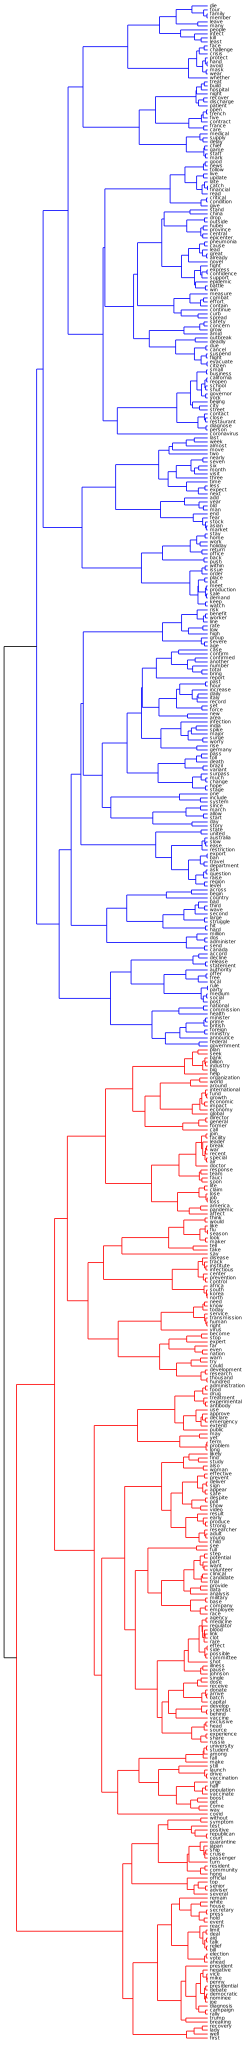

In [ ]:
names = list(G.nodes)
image = svg_dendrogram(dendrogram, names, n_clusters=2, rotate=True,width=500,height=5000,filename='community_dendogram2_all_periods')
SVG(image)

**Metrics**

In [ ]:
nodelist = list(G.nodes)
labels = list(cut_straight(dendrogram, n_clusters=2, return_dendrogram=False))

community_dend = [[],[]]
i = 0
for node in nodelist:
  community_dend[labels[i]].append(node)
  i += 1

In [ ]:
_ = compute_metrics(G, community_dend)

Coverage:  0.5837088966783509
Performance:  0.5161734449205637
Modularity:  0.11894140146706264


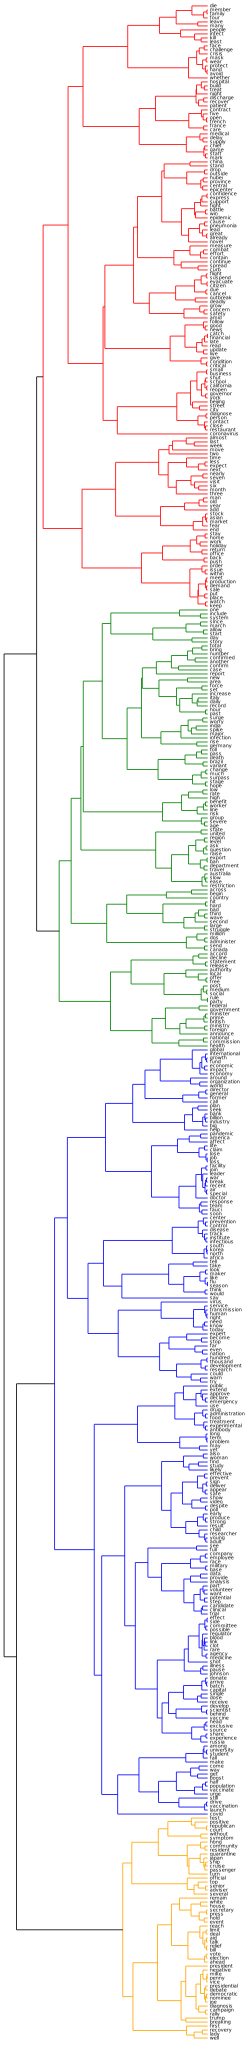

In [ ]:
image = svg_dendrogram(dendrogram, names, n_clusters=4, rotate=True,width=500,height=5000,filename='community_dendogram4_all_periods')
SVG(image)

**Metrics**

In [ ]:
nodelist = list(G.nodes)
labels = list(cut_straight(dendrogram, n_clusters=4, return_dendrogram=False))

community_dend = [[],[],[],[]]
i = 0
for node in nodelist:
  community_dend[labels[i]].append(node)
  i += 1

In [ ]:
_ = compute_metrics(G, community_dend)

Coverage:  0.3758137205808713
Performance:  0.6892780347446746
Modularity:  0.14774572873120667


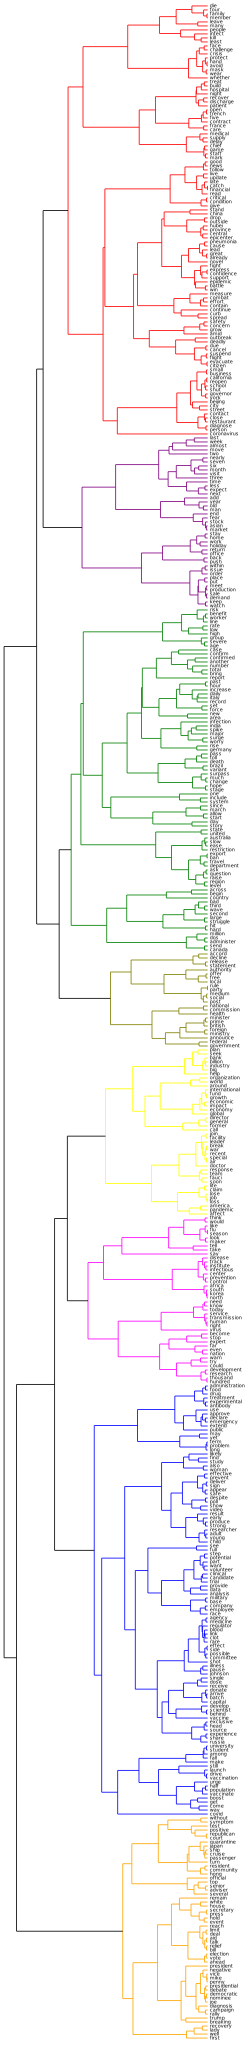

In [ ]:
image = svg_dendrogram(dendrogram, names, n_clusters=8, rotate=True,width=500,height=5000,filename='community_dendogram8_all_periods')
SVG(image)

**Metrics**

In [ ]:
nodelist = list(G.nodes)
labels = list(cut_straight(dendrogram, n_clusters=8, return_dendrogram=False))

community_dend = [[],[],[],[],[],[],[],[]]
i = 0
for node in nodelist:
  community_dend[labels[i]].append(node)
  i += 1

In [ ]:
_ = compute_metrics(G, community_dend)

Coverage:  0.26039058587881825
Performance:  0.8035827545132497
Modularity:  0.14666265125458805


### Girvan_Newman: not working!

In [ ]:
community_gn = community.girvan_newman(G)
k = 2
i = 1
for comm in itertools.islice(community_gn, k):
  if i == 2:
    for x in range(len(comm)):
      print(sorted(comm[x]))
  i += 1

['accord', 'across', 'add', 'administer', 'administration', 'adult', 'adviser', 'affect', 'africa', 'age', 'agency', 'ahead', 'aid', 'air', 'allow', 'almost', 'already', 'also', 'amid', 'among', 'analysis', 'announce', 'another', 'antibody', 'appear', 'approve', 'area', 'around', 'arrive', 'asian', 'ask', 'australia', 'authority', 'avoid', 'back', 'bad', 'ban', 'bank', 'base', 'batch', 'battle', 'become', 'begin', 'behind', 'beijing', 'benefit', 'big', 'bill', 'billion', 'blood', 'boost', 'brazil', 'break', 'breaking', 'bring', 'british', 'build', 'business', 'california', 'call', 'campaign', 'canada', 'cancel', 'candidate', 'capital', 'care', 'case', 'catch', 'cause', 'center', 'central', 'challenge', 'change', 'chief', 'child', 'china', 'citizen', 'city', 'claim', 'clinical', 'close', 'clot', 'combat', 'come', 'commission', 'committee', 'community', 'company', 'concern', 'condition', 'confidence', 'confirm', 'confirmed', 'contact', 'contain', 'continue', 'contract', 'control', 'coron

In [ ]:
# VERY HEAVY COMPUTATION
def most_central_edge(G):
  centrality = betweenness(G, weight="weight")
  return max(centrality, key=centrality.get)

community_gn_centrality = community.girvan_newman(G, most_valuable_edge=most_central_edge)
tuple(print(sorted(c)) for c in next(community_gn_centrality))

In [ ]:
def heaviest(G):
  u, v, w = max(G.edges(data="weight"), key=itemgetter(2))
  return (u, v)

community_gn_heaviest = community.girvan_newman(G, most_valuable_edge=heaviest)
tuple(print(sorted(c)) for c in next(community_gn_heaviest))

['accord', 'across', 'add', 'administer', 'administration', 'adult', 'adviser', 'affect', 'africa', 'age', 'agency', 'ahead', 'aid', 'air', 'allow', 'almost', 'already', 'also', 'america', 'amid', 'among', 'analysis', 'announce', 'another', 'antibody', 'appear', 'approve', 'area', 'around', 'arrive', 'asian', 'ask', 'australia', 'authority', 'avoid', 'back', 'bad', 'ban', 'bank', 'base', 'batch', 'battle', 'become', 'begin', 'behind', 'beijing', 'benefit', 'big', 'bill', 'billion', 'blood', 'boost', 'brazil', 'break', 'breaking', 'bring', 'british', 'build', 'business', 'california', 'call', 'campaign', 'canada', 'cancel', 'candidate', 'capital', 'care', 'case', 'catch', 'cause', 'center', 'central', 'challenge', 'change', 'chief', 'child', 'china', 'citizen', 'city', 'claim', 'clinical', 'close', 'clot', 'combat', 'come', 'commission', 'committee', 'community', 'company', 'concern', 'condition', 'confidence', 'confirm', 'confirmed', 'contact', 'contain', 'continue', 'contract', 'contr

(None, None)

### Clique percolation: heavy!

In [ ]:
cliques = nx.find_cliques(G)

In [ ]:
k = 5
community_clique = community.k_clique_communities(G, k, cliques)

In [ ]:
c = next(community_clique)

## **JanFeb2020**

### Download data

In [ ]:
period = '_JanFeb2020'
China = pd.read_csv('/content/China'+period+'.csv')
USA = pd.read_csv('/content/USA'+period+'.csv',)

edges = pd.read_csv('/content/edgelist_China_USA'+period+'.csv')
edges_China = pd.read_csv('/content/edgelist_China'+period+'.csv')
edges_USA = pd.read_csv('/content/edgelist_USA'+period+'.csv')

nodes = pd.read_csv('/content/nodelist_China_USA'+period+'.csv')

text_China = extract_text(China)
text_USA = extract_text(USA)

freq_dict_China = frequency_dictionary(text_China)
freq_dict_China = dict(sorted(freq_dict_China.items(), key=lambda item: item[1], reverse = True))   #order from more frequent to less frequent word

freq_dict_USA = frequency_dictionary(text_USA)
freq_dict_USA = dict(sorted(freq_dict_USA.items(), key=lambda item: item[1], reverse = True))   #order from more frequent to less frequent word

net, net_df = network_from_edges(edges)
net_China, _ = network_from_edges(edges_China)
net_USA, _ = network_from_edges(edges_USA)
G = get_graph(net)
G_China = get_graph(net_China)
G_USA = get_graph(net_USA)

In [ ]:
print('China&USA:')
print('Nodes: ',len(G.nodes()))
print('Edges: ',len(G.edges()))
print('Is connected: ',nx.is_connected(G))
print()
print('China:')
print('Words: ',len(freq_dict_China))
print()
print('USA:')
print('Words: ',len(freq_dict_USA))

China&USA:
Nodes:  454
Edges:  3254
Is connected:  True

China:
Words:  10192

USA:
Words:  10601


### Bipartition
Partition a graph into two blocks using the Kernighan–Lin algorithm.

In [ ]:
community_bipart = community.kernighan_lin_bisection(G,weight='weight')

In [ ]:
print(community_bipart[0])
print(community_bipart[1])

{'mother', 'screen', 'set', 'dozen', 'border', 'tell', 'pandemic', 'east', 'flu', 'street', 'trump', 'six', 'party', 'shortage', 'restriction', 'severe', 'share', 'receive', 'best', 'contract', 'several', 'dollar', 'family', 'australian', 'affect', 'wish', 'possible', 'situation', 'increase', 'community', 'quarter', 'infectious', 'strain', 'care', 'come', 'recovery', 'develop', 'low', 'cut', 'illness', 'daily', 'cancel', 'whether', 'demand', 'wang', 'nine', 'special', 'student', 'service', 'reporter', 'baby', 'france', 'isolation', 'visit', 'woman', 'headline', 'strand', 'social', 'force', 'threat', 'good', 'front', 'full', 'major', 'also', 'check', 'appear', 'tokyo', 'almost', 'yuan', 'result', 'place', 'fast', 'sell', 'look', 'still', 'scientist', 'fall', 'last', 'cough', 'source', 'would', 'california', 'medicine', 'put', 'leader', 'fly', 'meeting', 'ensure', 'read', 'research', 'medic', 'charter', 'plane', 'turn', 'korea', 'information', 'today', 'investor', 'evacuee', 'surgical', 

In [ ]:
threshold = 0.00001
sum_China_0, sum_USA_0, sum_China_USA_0 = community_check(community_bipart[0], freq_dict_China, freq_dict_USA, G_China, G_USA, threshold)
sum_China_1, sum_USA_1, sum_China_USA_1 = community_check(community_bipart[1], freq_dict_China, freq_dict_USA, G_China, G_USA, threshold)

In [ ]:
print('First community:')
print('China: ', round(100 * sum_China_0 / len(community_bipart[0])),'%')
print('USA: ', round(100 * sum_USA_0 / len(community_bipart[0])),'%')
print('China&USA: ', round(100 * sum_China_USA_0 / len(community_bipart[0])),'%')
print()
print('China: ', round(100 * sum_China_1 / len(community_bipart[1])),'%')
print('USA: ', round(100 * sum_USA_1 / len(community_bipart[1])),'%')
print('China&USA: ', round(100 * sum_China_USA_1 / len(community_bipart[1])),'%')

First community:
China:  43 %
USA:  52 %
China&USA:  4 %

China:  45 %
USA:  51 %
China&USA:  4 %


**Metrics**

In [ ]:
_ = compute_metrics(G, community_bipart)

Coverage:  0.8097725875845113
Performance:  0.5207087356925441
Modularity:  0.000738799589312081


### Modularity-based communities
Find communities in G using greedy modularity maximization.

In [ ]:
community_mod = community.greedy_modularity_communities(G, n_communities=2, weight='weight')
# communities_naive_mod = community.naive_greedy_modularity_communities(G)

In [ ]:
community_mod_list = []
for comm in community_mod:
 print(list(comm))
 community_mod_list.append(list(comm))

['know', 'screen', 'set', 'dozen', 'economy', 'high', 'flu', 'street', 'six', 'may', 'restriction', 'share', 'far', 'market', 'contract', 'several', 'dollar', 'australian', 'family', 'affect', 'department', 'possible', 'coronavirus', 'hit', 'quarter', 'strain', 'come', 'low', 'cut', 'illness', 'cancel', 'whether', 'demand', 'nine', 'headline', 'woman', 'strand', 'business', 'force', 'social', 'good', 'front', 'appear', 'tokyo', 'almost', 'flight', 'result', 'place', 'sell', 'still', 'fall', 'last', 'cough', 'source', 'california', 'fly', 'meeting', 'return', 'rate', 'charter', 'turn', 'korea', 'today', 'investor', 'evacuee', 'raise', 'contact', 'wear', 'much', 'provide', 'bank', 'head', 'order', 'base', 'keep', 'hand', 'move', 'like', 'university', 'five', 'four', 'growth', 'plan', 'asian', 'respiratory', 'limit', 'firm', 'thailand', 'travel', 'citizen', 'big', 'despite', 'grow', 'system', 'see', 'news', 'south', 'watch', 'panic', 'close', 'officer', 'level', 'fear', 'story', 'drug', '

In [ ]:
threshold = 0.00001
for i in range(len(community_mod_list)):
  sum_China, sum_USA, sum_China_USA = community_check(community_mod_list[i], freq_dict_China, freq_dict_USA, G_China, G_USA, threshold)
  print('Community: ', i)
  print('China: ', round(100 * sum_China / len(community_mod_list[i])),'%')
  print('USA: ', round(100 * sum_USA / len(community_mod_list[i])),'%')
  print('China&USA: ', round(100 * sum_China_USA / len(community_mod_list[i])),'%')
  print()

Community:  0
China:  26 %
USA:  69 %
China&USA:  4 %

Community:  1
China:  63 %
USA:  34 %
China&USA:  2 %

Community:  2
China:  46 %
USA:  46 %
China&USA:  8 %

Community:  3
China:  76 %
USA:  20 %
China&USA:  5 %

Community:  4
China:  47 %
USA:  47 %
China&USA:  6 %

Community:  5
China:  19 %
USA:  78 %
China&USA:  0 %

Community:  6
China:  29 %
USA:  71 %
China&USA:  0 %



**Metrics**

In [ ]:
_ = compute_metrics(G, community_mod_list)

Coverage:  0.4164105716041795
Performance:  0.7469342902432146
Modularity:  0.21828728489729782


In [ ]:
colors = list(G.nodes)
i = 0
dict_nodes = {}
for node in colors:
  if node in community_mod_list[0]:
    colors[i] = 'violet'
    dict_nodes[node] = 0
  if node in community_mod_list[1]:
    colors[i] = 'lightcoral'
    dict_nodes[node] = 1
  if node in community_mod_list[2]:
    colors[i] = 'lawngreen'
    dict_nodes[node] = 2
  if node in community_mod_list[3]:
    colors[i] = 'cyan'
    dict_nodes[node] = 3
  if node in community_mod_list[4]:
    colors[i] = 'dodgerblue'
    dict_nodes[node] = 4
  if node in community_mod_list[5]:
    colors[i] = 'yellow'
    dict_nodes[node] = 5
  if node in community_mod_list[6]:
    colors[i] = 'pink'
    dict_nodes[node] = 6
  i += 1

In [ ]:
pos = community_layout(G, dict_nodes)
fig = plt.figure(1, figsize=(200, 80), dpi=60)
nx.draw_networkx(G, pos, node_color=colors, node_size=5000, with_labels=True,
                 font_size =50,width=0.05)
plt.show()

### Louvain Community Detection
Find the best partition of a graph using the Louvain Community Detection Algorithm.

In [ ]:
# communities_louvain = community.louvain.louvain_communities(G)
# partitions_louvain = community.louvain.louvain_partitions(G)

community_louv = community_louvain.best_partition(G,weight='weight')

# modularity_louvain = community.modularity(communities_louvain, G) # ERROR: not a partition
# print("The modularity Q based on networkx is {}".format(modularity_louvain))

In [ ]:
max = np.max(list(community_louv.values()))
community_louvain_list = []
for i in range(max+1):
  community_louvain_list.append([])
for key in list(community_louv.keys()):
  community_louvain_list[community_louv[key]].append(key)
for i in range(max+1):
  print(community_louvain_list[i])

['outside', 'confirm', 'case', 'central', 'epicenter', 'hubei', 'province', 'number', 'drop', 'day', 'include', 'critical', 'total', 'one', 'new', 'end', 'three', 'die', 'miss', 'authority', 'pneumonia', 'death', 'confirmed', 'dead', 'discharge', 'first', 'report', 'suspected', 'toll', 'another', 'macao', 'taiwan', 'infection', 'recover', 'bring', 'rise', 'man', 'region', 'pass', 'record', 'france', 'release', 'reach', 'suspect', 'condition', 'data']
['talk', 'china', 'coronavirus', 'novel', 'outbreak', 'university', 'student', 'face', 'deal', 'medium', 'watch', 'make', 'take', 'hard', 'announce', 'team', 'expert', 'among', 'country', 'asia', 'state', 'information', 'office', 'across', 'line', 'since', 'medic', 'arrive', 'support', 'local', 'help', 'fight', 'cut', 'firm', 'express', 'contain', 'epidemic', 'nearly', 'risk', 'drug', 'ensure', 'supply', 'give', 'trump', 'try', 'share', 'effort', 'send', 'amid', 'offer', 'system', 'foreign', 'wang', 'mask', 'donate', 'show', 'australia', '

In [ ]:
threshold = 0.00001
for i in range(len(community_louvain_list)):
  sum_China, sum_USA, sum_China_USA = community_check(community_louvain_list[i], freq_dict_China, freq_dict_USA, G_China, G_USA, threshold)
  print('Community: ', i)
  print('China: ', round(100 * sum_China / len(community_louvain_list[i])),'%')
  print('USA: ', round(100 * sum_USA / len(community_louvain_list[i])),'%')
  print('China&USA: ', round(100 * sum_China_USA / len(community_louvain_list[i])),'%')
  print()

Community:  0
China:  46 %
USA:  48 %
China&USA:  7 %

Community:  1
China:  43 %
USA:  53 %
China&USA:  3 %

Community:  2
China:  76 %
USA:  21 %
China&USA:  3 %

Community:  3
China:  25 %
USA:  75 %
China&USA:  0 %

Community:  4
China:  17 %
USA:  76 %
China&USA:  3 %

Community:  5
China:  50 %
USA:  41 %
China&USA:  9 %



**Metrics**

In [ ]:
_ = compute_metrics(G, community_louvain_list)

Coverage:  0.49354640442532266
Performance:  0.5723274109947389
Modularity:  0.2201757877049788


In [ ]:
colors = list(community_louv.values())

colors[:] = [x if x != 0 else 'violet' for x in colors]
colors[:] = [x if x != 1 else 'lawngreen' for x in colors]
colors[:] = [x if x != 2 else 'dodgerblue' for x in colors]
colors[:] = [x if x != 3 else 'pink' for x in colors]
colors[:] = [x if x != 4 else 'lightcoral' for x in colors]
colors[:] = [x if x != 5 else 'cyan' for x in colors]

In [ ]:
pos = community_layout(G, community_louv)
fig = plt.figure(1, figsize=(200, 80), dpi=60)
nx.draw_networkx(G, pos, node_color=colors, node_size=5000, with_labels=True,
                 font_size =50,width=0.05)
plt.show()

### Dendogram

In [ ]:
paris = Paris()
adjacency = nx.convert_matrix.to_numpy_array(G, nodelist = list(G.nodes))
dendrogram = paris.fit_transform(adjacency)

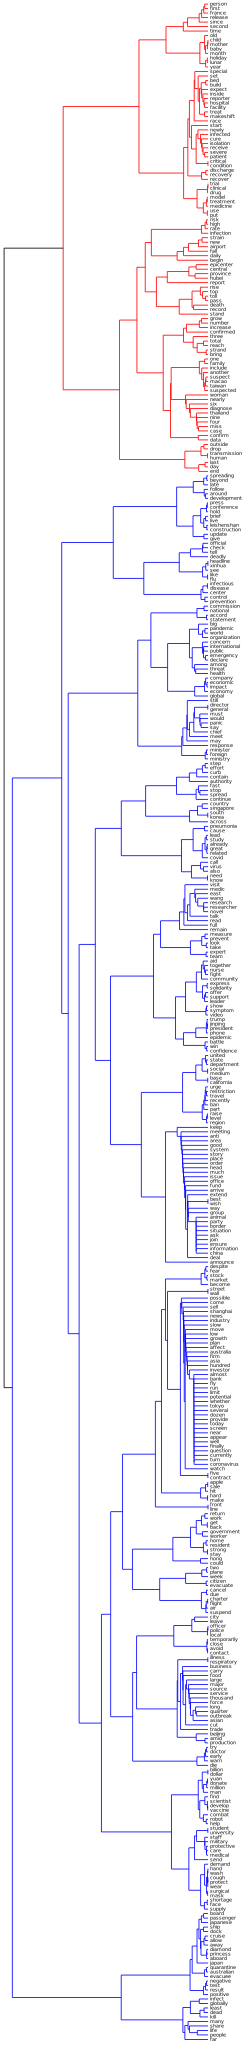

In [ ]:
names = list(G.nodes)
image = svg_dendrogram(dendrogram, names, n_clusters=2, rotate=True,width=500,height=5000,filename='community_dendogram2'+period)
SVG(image)

**Metrics**

In [ ]:
nodelist = list(G.nodes)
labels = list(cut_straight(dendrogram, n_clusters=2, return_dendrogram=False))

community_dend = [[],[]]
i = 0
for node in nodelist:
  community_dend[labels[i]].append(node)
  i += 1

In [ ]:
_ = compute_metrics(G, community_dend)

Coverage:  0.7271051014136447
Performance:  0.3707345061314195
Modularity:  0.14921324735116914


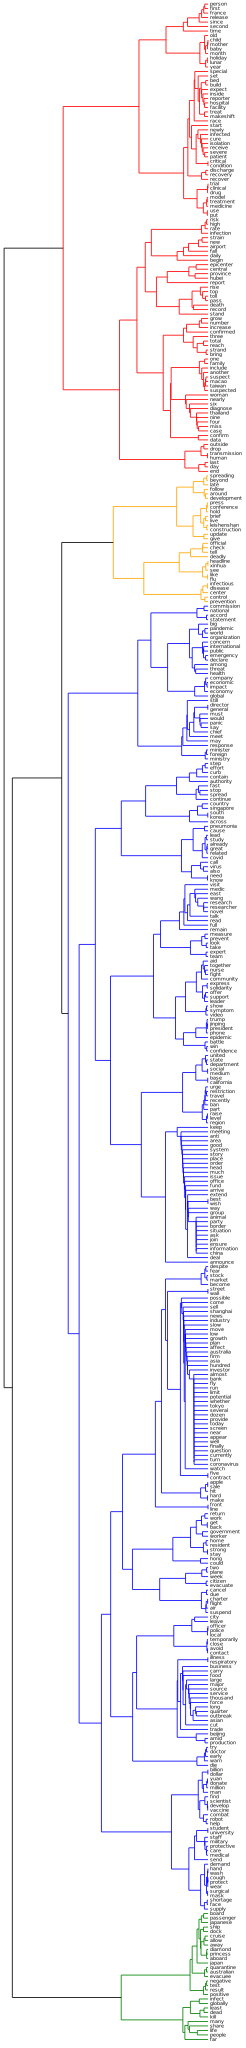

In [ ]:
image = svg_dendrogram(dendrogram, names, n_clusters=4, rotate=True,width=500,height=5000,filename='community_dendogram4'+period)
SVG(image)

**Metrics**

In [ ]:
nodelist = list(G.nodes)
labels = list(cut_straight(dendrogram, n_clusters=4, return_dendrogram=False))

community_dend = [[],[],[],[]]
i = 0
for node in nodelist:
  community_dend[labels[i]].append(node)
  i += 1

In [ ]:
_ = compute_metrics(G, community_dend)

Coverage:  0.5998770743700061
Performance:  0.5349943110540596
Modularity:  0.1907479504117315


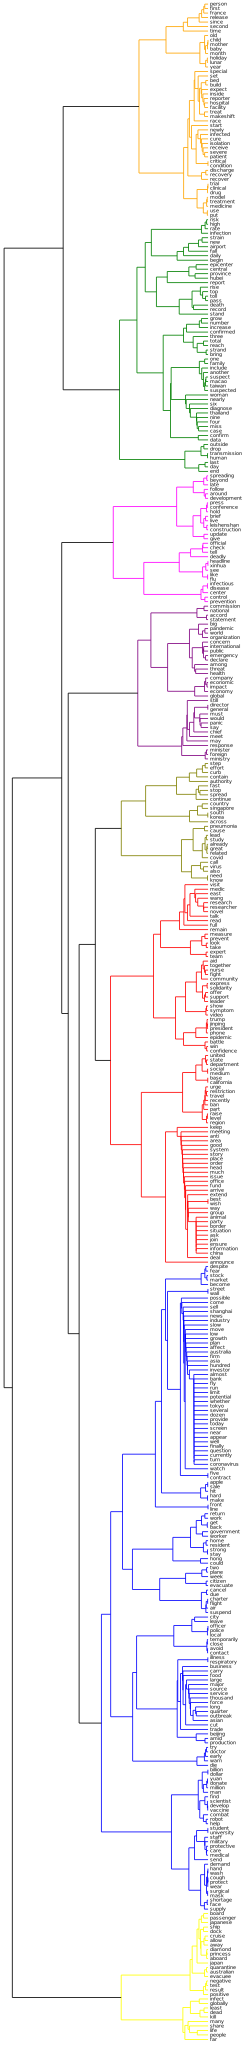

In [ ]:
image = svg_dendrogram(dendrogram, names, n_clusters=8, rotate=True,width=500,height=5000,filename='community_dendogram8'+period)
SVG(image)

**Metrics**

In [ ]:
nodelist = list(G.nodes)
labels = list(cut_straight(dendrogram, n_clusters=8, return_dendrogram=False))

community_dend = [[],[],[],[],[],[],[],[]]
i = 0
for node in nodelist:
  community_dend[labels[i]].append(node)
  i += 1

In [ ]:
_ = compute_metrics(G, community_dend)

Coverage:  0.3574062692071297
Performance:  0.8125468000894672
Modularity:  0.19691215237768522


## **SeptOct2020**

### Download data

In [ ]:
period = '_SeptOct2020'
China = pd.read_csv('/content/China'+period+'.csv')
USA = pd.read_csv('/content/USA'+period+'.csv',)

edges = pd.read_csv('/content/edgelist_China_USA'+period+'.csv')
edges_China = pd.read_csv('/content/edgelist_China'+period+'.csv')
edges_USA = pd.read_csv('/content/edgelist_USA'+period+'.csv')

nodes = pd.read_csv('/content/nodelist_China_USA'+period+'.csv')

text_China = extract_text(China)
text_USA = extract_text(USA)

freq_dict_China = frequency_dictionary(text_China)
freq_dict_China = dict(sorted(freq_dict_China.items(), key=lambda item: item[1], reverse = True))   #order from more frequent to less frequent word

freq_dict_USA = frequency_dictionary(text_USA)
freq_dict_USA = dict(sorted(freq_dict_USA.items(), key=lambda item: item[1], reverse = True))   #order from more frequent to less frequent word

net, net_df = network_from_edges(edges)
net_China, _ = network_from_edges(edges_China)
net_USA, _ = network_from_edges(edges_USA)
G = get_graph(net)
G_China = get_graph(net_China)
G_USA = get_graph(net_USA)

In [ ]:
print('China&USA:')
print('Nodes: ',len(G.nodes()))
print('Edges: ',len(G.edges()))
print('Is connected: ',nx.is_connected(G))
print()
print('China:')
print('Words: ',len(freq_dict_China))
print()
print('USA:')
print('Words: ',len(freq_dict_USA))

China&USA:
Nodes:  507
Edges:  5768
Is connected:  True

China:
Words:  6219

USA:
Words:  19457


### Bipartition
Partition a graph into two blocks using the Kernighan–Lin algorithm.

In [ ]:
community_bipart = community.kernighan_lin_bisection(G,weight='weight')

In [ ]:
print(community_bipart[0])
print(community_bipart[1])

{'prevention', 'nationwide', 'approval', 'live', 'restaurant', 'bill', 'qingdao', 'novel', 'ahead', 'flu', 'street', 'party', 'six', 'trillion', 'resurgence', 'prevent', 'nancy', 'press', 'severe', 'share', 'market', 'immune', 'supporter', 'receive', 'director', 'several', 'supply', 'benefit', 'family', 'review', 'bar', 'half', 'contain', 'effect', 'crisis', 'possible', 'feel', 'recent', 'secretary', 'milestone', 'side', 'outside', 'amy', 'sen', 'think', 'battle', 'update', 'italy', 'epidemic', 'previous', 'send', 'whether', 'demand', 'nine', 'play', 'reduce', 'speaker', 'student', 'maker', 'service', 'self', 'woman', 'package', 'business', 'effort', 'pay', 'social', 'likely', 'political', 'strong', 'seven', 'good', 'resident', 'message', 'full', 'third', 'also', 'free', 'north', 'major', 'federal', 'institute', 'task', 'almost', 'flight', 'place', 'town', 'look', 'scientist', 'senate', 'soon', 'plastic', 'game', 'impose', 'jersey', 'without', 'push', 'player', 'support', 'vulnerable',

In [ ]:
threshold = 0.00001
sum_China_0, sum_USA_0, sum_China_USA_0 = community_check(community_bipart[0], freq_dict_China, freq_dict_USA, G_China, G_USA, threshold)
sum_China_1, sum_USA_1, sum_China_USA_1 = community_check(community_bipart[1], freq_dict_China, freq_dict_USA, G_China, G_USA, threshold)

In [ ]:
print('First community:')
print('China: ', round(100 * sum_China_0 / len(community_bipart[0])),'%')
print('USA: ', round(100 * sum_USA_0 / len(community_bipart[0])),'%')
print('China&USA: ', round(100 * sum_China_USA_0 / len(community_bipart[0])),'%')
print()
print('China: ', round(100 * sum_China_1 / len(community_bipart[1])),'%')
print('USA: ', round(100 * sum_USA_1 / len(community_bipart[1])),'%')
print('China&USA: ', round(100 * sum_China_USA_1 / len(community_bipart[1])),'%')

First community:
China:  29 %
USA:  64 %
China&USA:  6 %

China:  39 %
USA:  57 %
China&USA:  5 %


**Metrics**

In [ ]:
_ = compute_metrics(G, community_bipart)

Coverage:  0.715499306518724
Performance:  0.5203670354172026
Modularity:  0.0017986458598422284


### Modularity-based communities
Find communities in G using greedy modularity maximization.

In [ ]:
community_mod = community.greedy_modularity_communities(G, n_communities=2, weight='weight')
# communities_naive_mod = community.naive_greedy_modularity_communities(G)

In [ ]:
community_mod_list = []
for comm in community_mod:
 print(list(comm))
 community_mod_list.append(list(comm))

['know', 'pause', 'approval', 'rule', 'flu', 'show', 'party', 'may', 'early', 'severe', 'share', 'market', 'immune', 'receive', 'dose', 'supply', 'benefit', 'review', 'effect', 'contain', 'possible', 'develop', 'side', 'antibody', 'illness', 'battle', 'covid', 'two', 'response', 'play', 'reduce', 'make', 'service', 'maker', 'fight', 'authorization', 'exclusive', 'follow', 'woman', 'concern', 'experimental', 'work', 'pay', 'social', 'likely', 'sign', 'strong', 'resident', 'full', 'free', 'third', 'late', 'appear', 'institute', 'result', 'johnson', 'want', 'coverage', 'end', 'scientist', 'stage', 'use', 'soon', 'plastic', 'clear', 'would', 'push', 'vaccine', 'support', 'win', 'raise', 'company', 'french', 'join', 'term', 'provide', 'employee', 'bank', 'age', 'emergency', 'head', 'post', 'season', 'meet', 'like', 'protest', 'activity', 'challenge', 'serious', 'infect', 'find', 'deal', 'plan', 'old', 'worry', 'offer', 'firm', 'minister', 'seek', 'despite', 'participant', 'protocol', 'facil

In [ ]:
threshold = 0.00001
for i in range(len(community_mod_list)):
  sum_China, sum_USA, sum_China_USA = community_check(community_mod_list[i], freq_dict_China, freq_dict_USA, G_China, G_USA, threshold)
  print('Community: ', i)
  print('China: ', round(100 * sum_China / len(community_mod_list[i])),'%')
  print('USA: ', round(100 * sum_USA / len(community_mod_list[i])),'%')
  print('China&USA: ', round(100 * sum_China_USA / len(community_mod_list[i])),'%')
  print()

Community:  0
China:  23 %
USA:  72 %
China&USA:  5 %

Community:  1
China:  30 %
USA:  65 %
China&USA:  5 %

Community:  2
China:  50 %
USA:  44 %
China&USA:  6 %

Community:  3
China:  50 %
USA:  50 %
China&USA:  0 %

Community:  4
China:  25 %
USA:  75 %
China&USA:  0 %

Community:  5
China:  0 %
USA:  100 %
China&USA:  0 %



**Metrics**

In [ ]:
_ = compute_metrics(G, community_mod_list)

Coverage:  0.5409153952843273
Performance:  0.691582664826812
Modularity:  0.22681624599609804


In [ ]:
colors = list(G.nodes)
i = 0
dict_nodes = {}
for node in colors:
  if node in community_mod_list[0]:
    colors[i] = 'violet'
    dict_nodes[node] = 0
  if node in community_mod_list[1]:
    colors[i] = 'lightcoral'
    dict_nodes[node] = 1
  if node in community_mod_list[2]:
    colors[i] = 'lawngreen'
    dict_nodes[node] = 2
  if node in community_mod_list[3]:
    colors[i] = 'cyan'
    dict_nodes[node] = 3
  if node in community_mod_list[4]:
    colors[i] = 'dodgerblue'
    dict_nodes[node] = 4
  if node in community_mod_list[5]:
    colors[i] = 'yellow'
    dict_nodes[node] = 5
  i += 1

In [ ]:
pos = community_layout(G, dict_nodes)
fig = plt.figure(1, figsize=(200, 80), dpi=60)
nx.draw_networkx(G, pos, node_color=colors, node_size=5000, with_labels=True,
                 font_size =50,width=0.05)
plt.show()

### Louvain Community Detection
Find the best partition of a graph using the Louvain Community Detection Algorithm.

In [ ]:
# communities_louvain = community.louvain.louvain_communities(G)
# partitions_louvain = community.louvain.louvain_partitions(G)

community_louv = community_louvain.best_partition(G,weight='weight')

# modularity_louvain = community.modularity(communities_louvain, G) # ERROR: not a partition
# print("The modularity Q based on networkx is {}".format(modularity_louvain))

In [ ]:
max = np.max(list(community_louv.values()))
community_louvain_list = []
for i in range(max+1):
  community_louvain_list.append([])
for key in list(community_louv.keys()):
  community_louvain_list[community_louv[key]].append(key)
for i in range(max+1):
  print(community_louvain_list[i])

['get', 'sign', 'emergency', 'data', 'follow', 'show', 'single', 'russia', 'may', 'compare', 'part', 'vaccine', 'use', 'produce', 'development', 'immunity', 'study', 'researcher', 'potential', 'drug', 'response', 'illness', 'source', 'infect', 'news', 'approve', 'make', 'work', 'due', 'candidate', 'clinical', 'trial', 'johnson', 'immune', 'old', 'early', 'company', 'stage', 'food', 'would', 'strong', 'coverage', 'participant', 'scientist', 'young', 'experimental', 'volunteer', 'safe', 'result', 'plan', 'receive', 'enough', 'develop', 'want', 'clear', 'antibody', 'appear', 'safety', 'adult', 'exclusive', 'share', 'pause', 'dose', 'institute', 'approval', 'head', 'promise', 'available', 'soon', 'pay', 'real', 'shot', 'authorization', 'serious', 'review', 'maker']
['covid', 'around', 'concern', 'pandemic', 'many', 'among', 'late', 'global', 'people', 'raise', 'amid', 'patient', 'africa', 'disease', 'control', 'world', 'push', 'china', 'back', 'lead', 'severe', 'gathering', 'organization',

In [ ]:
threshold = 0.00001
for i in range(len(community_louvain_list)):
  sum_China, sum_USA, sum_China_USA = community_check(community_louvain_list[i], freq_dict_China, freq_dict_USA, G_China, G_USA, threshold)
  print('Community: ', i)
  print('China: ', round(100 * sum_China / len(community_louvain_list[i])),'%')
  print('USA: ', round(100 * sum_USA / len(community_louvain_list[i])),'%')
  print('China&USA: ', round(100 * sum_China_USA / len(community_louvain_list[i])),'%')
  print()

Community:  0
China:  22 %
USA:  75 %
China&USA:  3 %

Community:  1
China:  30 %
USA:  64 %
China&USA:  5 %

Community:  2
China:  52 %
USA:  42 %
China&USA:  6 %

Community:  3
China:  30 %
USA:  63 %
China&USA:  6 %



**Metrics**

In [ ]:
_ = compute_metrics(G, community_louvain_list)

Coverage:  0.494625520110957
Performance:  0.7328078833095556
Modularity:  0.22832371003861535


In [ ]:
colors = list(community_louv.values())

colors[:] = [x if x != 0 else 'violet' for x in colors]
colors[:] = [x if x != 1 else 'dodgerblue' for x in colors]
colors[:] = [x if x != 2 else 'lawngreen' for x in colors]
colors[:] = [x if x != 3 else 'lightcoral' for x in colors]

In [ ]:
pos = community_layout(G, community_louv)
fig = plt.figure(1, figsize=(200, 80), dpi=60)
nx.draw_networkx(G, pos, node_color=colors, node_size=5000, with_labels=True,
                 font_size =50,width=0.05)
plt.show()

### Dendogram

In [ ]:
paris = Paris()
adjacency = nx.convert_matrix.to_numpy_array(G, nodelist = list(G.nodes))
dendrogram = paris.fit_transform(adjacency)

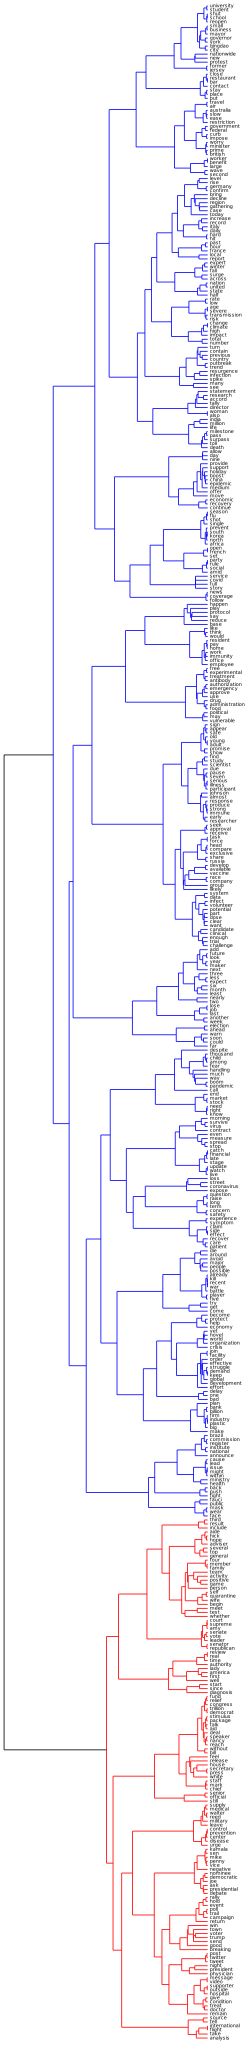

In [ ]:
names = list(G.nodes)
image = svg_dendrogram(dendrogram, names, n_clusters=2, rotate=True,width=500,height=5000,filename='community_dendogram2'+period)
SVG(image)

**Metrics**

In [ ]:
nodelist = list(G.nodes)
labels = list(cut_straight(dendrogram, n_clusters=2, return_dendrogram=False))

community_dend = [[],[]]
i = 0
for node in nodelist:
  community_dend[labels[i]].append(node)
  i += 1

In [ ]:
_ = compute_metrics(G, community_dend)

Coverage:  0.7335298196948682
Performance:  0.4030840953917877
Modularity:  0.14377128666610495


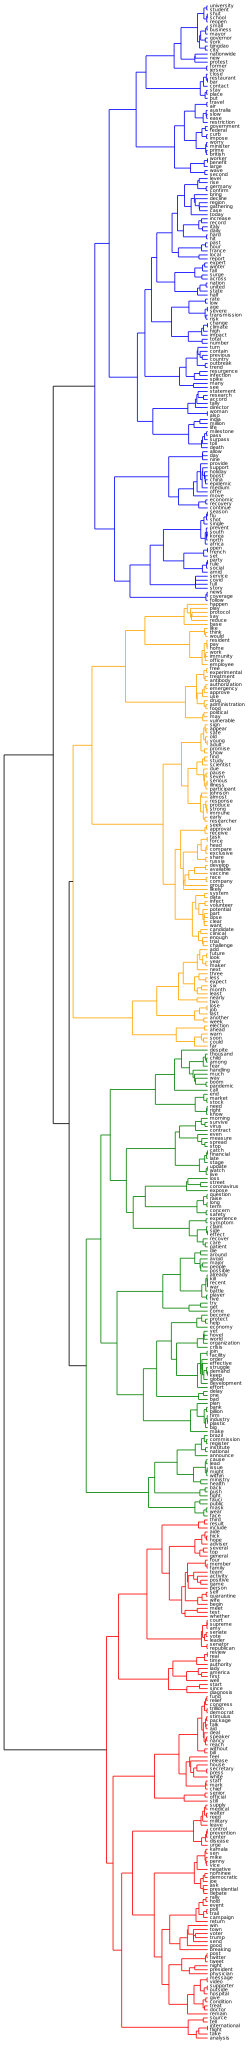

In [ ]:
image = svg_dendrogram(dendrogram, names, n_clusters=4, rotate=True,width=500,height=5000,filename='community_dendogram4'+period)
SVG(image)

**Metrics**

In [ ]:
nodelist = list(G.nodes)
labels = list(cut_straight(dendrogram, n_clusters=4, return_dendrogram=False))

community_dend = [[],[],[],[]]
i = 0
for node in nodelist:
  community_dend[labels[i]].append(node)
  i += 1

In [ ]:
_ = compute_metrics(G, community_dend)

Coverage:  0.4360263522884882
Performance:  0.7424203444270334
Modularity:  0.19129244555448705


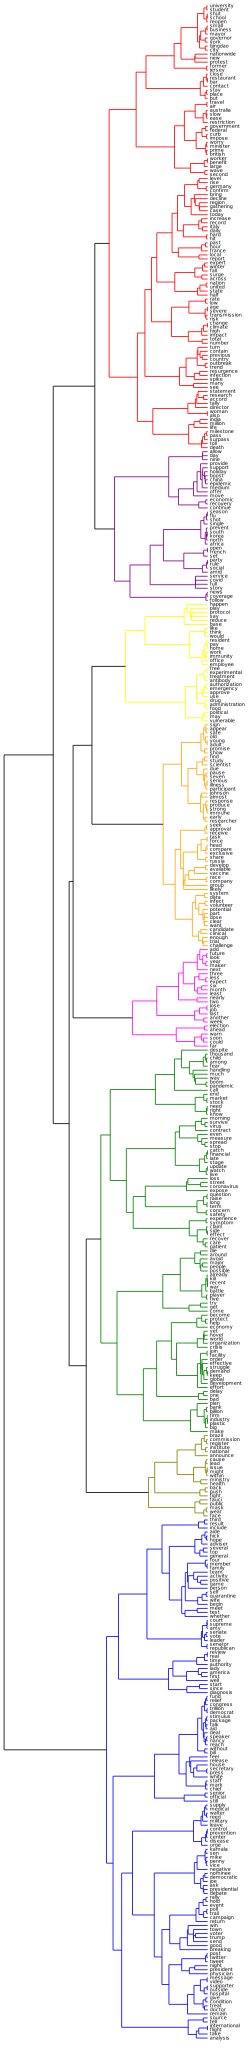

In [ ]:
image = svg_dendrogram(dendrogram, names, n_clusters=8, rotate=True,width=500,height=5000,filename='community_dendogram8'+period)
SVG(image)

**Metrics**

In [ ]:
nodelist = list(G.nodes)
labels = list(cut_straight(dendrogram, n_clusters=8, return_dendrogram=False))

community_dend = [[],[],[],[],[],[],[],[]]
i = 0
for node in nodelist:
  community_dend[labels[i]].append(node)
  i += 1

In [ ]:
_ = compute_metrics(G, community_dend)

Coverage:  0.3567961165048544
Performance:  0.8137536933523556
Modularity:  0.18146079609215154


## **MarchApril2021**

### Download data

In [ ]:
period = '_MarchApril2021'
China = pd.read_csv('/content/China'+period+'.csv')
USA = pd.read_csv('/content/USA'+period+'.csv',)

edges = pd.read_csv('/content/edgelist_China_USA'+period+'.csv')
edges_China = pd.read_csv('/content/edgelist_China'+period+'.csv')
edges_USA = pd.read_csv('/content/edgelist_USA'+period+'.csv')

nodes = pd.read_csv('/content/nodelist_China_USA'+period+'.csv')

text_China = extract_text(China)
text_USA = extract_text(USA)

freq_dict_China = frequency_dictionary(text_China)
freq_dict_China = dict(sorted(freq_dict_China.items(), key=lambda item: item[1], reverse = True))   #order from more frequent to less frequent word

freq_dict_USA = frequency_dictionary(text_USA)
freq_dict_USA = dict(sorted(freq_dict_USA.items(), key=lambda item: item[1], reverse = True))   #order from more frequent to less frequent word

net, net_df = network_from_edges(edges)
net_China, _ = network_from_edges(edges_China)
net_USA, _ = network_from_edges(edges_USA)
G = get_graph(net)
G_China = get_graph(net_China)
G_USA = get_graph(net_USA)

In [ ]:
print('China&USA:')
print('Nodes: ',len(G.nodes()))
print('Edges: ',len(G.edges()))
print('Is connected: ',nx.is_connected(G))
print()
print('China:')
print('Words: ',len(freq_dict_China))
print()
print('USA:')
print('Words: ',len(freq_dict_USA))

China&USA:
Nodes:  500
Edges:  3018
Is connected:  True

China:
Words:  5724

USA:
Words:  12540


### Bipartition
Partition a graph into two blocks using the Kernighan–Lin algorithm.

In [ ]:
community_bipart = community.kernighan_lin_bisection(G,weight='weight')

In [ ]:
print(community_bipart[0])
print(community_bipart[1])

{'public', 'investigation', 'measure', 'hop', 'decide', 'approval', 'governor', 'every', 'roll', 'tell', 'economy', 'authority', 'border', 'rule', 'protection', 'ahead', 'human', 'street', 'program', 'lead', 'trump', 'early', 'symptom', 'behind', 'target', 'beach', 'share', 'hope', 'contract', 'medium', 'several', 'claim', 'crisis', 'family', 'affect', 'recent', 'community', 'quarter', 'strain', 'come', 'campaign', 'step', 'mark', 'antibody', 'think', 'japan', 'illness', 'send', 'whether', 'demand', 'disorder', 'student', 'service', 'authorization', 'exclusive', 'agree', 'black', 'capital', 'woman', 'visit', 'effort', 'business', 'site', 'pay', 'social', 'likely', 'massive', 'seven', 'sign', 'resident', 'good', 'card', 'strong', 'full', 'major', 'die', 'late', 'also', 'institute', 'tokyo', 'almost', 'drop', 'result', 'place', 'want', 'hospitalization', 'reason', 'foreign', 'coverage', 'look', 'fourth', 'fully', 'scientist', 'source', 'game', 'impose', 'crowd', 'break', 'facebook', 'cal

In [ ]:
threshold = 0.00001
sum_China_0, sum_USA_0, sum_China_USA_0 = community_check(community_bipart[0], freq_dict_China, freq_dict_USA, G_China, G_USA, threshold)
sum_China_1, sum_USA_1, sum_China_USA_1 = community_check(community_bipart[1], freq_dict_China, freq_dict_USA, G_China, G_USA, threshold)

In [ ]:
print('First community:')
print('China: ', round(100 * sum_China_0 / len(community_bipart[0])),'%')
print('USA: ', round(100 * sum_USA_0 / len(community_bipart[0])),'%')
print('China&USA: ', round(100 * sum_China_USA_0 / len(community_bipart[0])),'%')
print()
print('China: ', round(100 * sum_China_1 / len(community_bipart[1])),'%')
print('USA: ', round(100 * sum_USA_1 / len(community_bipart[1])),'%')
print('China&USA: ', round(100 * sum_China_USA_1 / len(community_bipart[1])),'%')

First community:
China:  30 %
USA:  63 %
China&USA:  6 %

China:  39 %
USA:  59 %
China&USA:  2 %


**Metrics**

In [ ]:
_ = compute_metrics(G, community_bipart)

Coverage:  0.7809807819748178
Performance:  0.5145971943887776
Modularity:  -0.0042417157852895505


### Modularity-based communities
Find communities in G using greedy modularity maximization.

In [ ]:
community_mod = community.greedy_modularity_communities(G, n_communities=2, weight='weight')
# communities_naive_mod = community.naive_greedy_modularity_communities(G)

In [ ]:
community_mod_list = []
for comm in community_mod:
 print(list(comm))
 community_mod_list.append(list(comm))

['measure', 'set', 'every', 'border', 'economy', 'pandemic', 'high', 'rule', 'test', 'brazil', 'show', 'ahead', 'street', 'human', 'india', 'lead', 'early', 'symptom', 'share', 'behind', 'beach', 'intensive', 'restriction', 'claim', 'crisis', 'year', 'family', 'affect', 'global', 'month', 'increase', 'recent', 'coronavirus', 'hit', 'quarter', 'community', 'care', 'strain', 'positive', 'step', 'mark', 'low', 'think', 'japan', 'update', 'covid', 'daily', 'yunnan', 'demand', 'two', 'service', 'fight', 'france', 'time', 'total', 'spread', 'visit', 'capital', 'business', 'work', 'pay', 'origin', 'record', 'likely', 'massive', 'strong', 'seven', 'resident', 'next', 'analysis', 'major', 'third', 'die', 'day', 'institute', 'tokyo', 'almost', 'drop', 'place', 'coverage', 'fourth', 'toll', 'last', 'game', 'impose', 'crowd', 'california', 'push', 'surge', 'accord', 'forecast', 'research', 'return', 'week', 'rate', 'city', 'decline', 'detect', 'today', 'michigan', 'another', 'general', 'raise', 'c

In [ ]:
threshold = 0.00001
for i in range(len(community_mod_list)):
  sum_China, sum_USA, sum_China_USA = community_check(community_mod_list[i], freq_dict_China, freq_dict_USA, G_China, G_USA, threshold)
  print('Community: ', i)
  print('China: ', round(100 * sum_China / len(community_mod_list[i])),'%')
  print('USA: ', round(100 * sum_USA / len(community_mod_list[i])),'%')
  print('China&USA: ', round(100 * sum_China_USA / len(community_mod_list[i])),'%')
  print()

Community:  0
China:  39 %
USA:  54 %
China&USA:  6 %

Community:  1
China:  40 %
USA:  57 %
China&USA:  3 %

Community:  2
China:  17 %
USA:  81 %
China&USA:  1 %

Community:  3
China:  40 %
USA:  60 %
China&USA:  0 %

Community:  4
China:  12 %
USA:  82 %
China&USA:  6 %

Community:  5
China:  15 %
USA:  77 %
China&USA:  8 %

Community:  6
China:  55 %
USA:  45 %
China&USA:  0 %

Community:  7
China:  43 %
USA:  57 %
China&USA:  0 %

Community:  8
China:  0 %
USA:  100 %
China&USA:  0 %



**Metrics**

In [ ]:
_ = compute_metrics(G, community_mod_list)

Coverage:  0.5089463220675944
Performance:  0.7108216432865732
Modularity:  0.17671835270017283


In [ ]:
colors = list(G.nodes)
i = 0
dict_nodes = {}
for node in colors:
  if node in community_mod_list[0]:
    colors[i] = 'violet'
    dict_nodes[node] = 0
  if node in community_mod_list[1]:
    colors[i] = 'lightcoral'
    dict_nodes[node] = 1
  if node in community_mod_list[2]:
    colors[i] = 'lawngreen'
    dict_nodes[node] = 2
  if node in community_mod_list[3]:
    colors[i] = 'cyan'
    dict_nodes[node] = 3
  if node in community_mod_list[4]:
    colors[i] = 'dodgerblue'
    dict_nodes[node] = 4
  if node in community_mod_list[5]:
    colors[i] = 'yellow'
    dict_nodes[node] = 5
  if node in community_mod_list[6]:
    colors[i] = 'pink'
    dict_nodes[node] = 6
  if node in community_mod_list[7]:
    colors[i] = 'orange'
    dict_nodes[node] = 7
  if node in community_mod_list[8]:
    colors[i] = 'blue'
    dict_nodes[node] = 8
  i += 1

In [ ]:
pos = community_layout(G, dict_nodes)
fig = plt.figure(1, figsize=(200, 80), dpi=60)
nx.draw_networkx(G, pos, node_color=colors, node_size=5000, with_labels=True,
                 font_size =50,width=0.05)
plt.show()

### Louvain Community Detection
Find the best partition of a graph using the Louvain Community Detection Algorithm.

In [ ]:
# communities_louvain = community.louvain.louvain_communities(G)
# partitions_louvain = community.louvain.louvain_partitions(G)

community_louv = community_louvain.best_partition(G,weight='weight')

# modularity_louvain = community.modularity(communities_louvain, G) # ERROR: not a partition
# print("The modularity Q based on networkx is {}".format(modularity_louvain))

In [ ]:
max = np.max(list(community_louv.values()))
community_louvain_list = []
for i in range(max+1):
  community_louvain_list.append([])
for key in list(community_louv.keys()):
  community_louvain_list[community_louv[key]].append(key)
for i in range(max+1):
  print(community_louvain_list[i])

['death', 'toll', 'surpass', 'mark', 'third', 'rise', 'new', 'wave', 'virus', 'brazil', 'number', 'report', 'coronavirus', 'case', 'month', 'record', 'daily', 'high', 'surge', 'variant', 'hit', 'hour', 'bad', 'day', 'accord', 'time', 'total', 'set', 'state', 'city', 'data', 'amid', 'infection', 'show', 'average', 'every', 'india', 'spike', 'since', 'michigan', 'study', 'province', 'five', 'overseas', 'nearly', 'united', 'strain', 'york', 'local', 'yunnan', 'origin', 'decline', 'update', 'analysis', 'coverage']
['one', 'country', 'health', 'world', 'second', 'people', 'ministry', 'million', 'first', 'national', 'receive', 'least', 'dose', 'dos', 'adult', 'population', 'vaccinate', 'announce', 'jab', 'far', 'administer', 'around', 'public', 'authority', 'organization', 'across', 'china', 'office', 'two', 'official', 'become', 'donate', 'batch', 'arrive', 'half', 'prime', 'minister', 'register', 'foreign', 'president', 'detect', 'commission', 'joe', 'eligible', 'russia', 'animal', 'goal',

In [ ]:
threshold = 0.00001
for i in range(len(community_louvain_list)):
  sum_China, sum_USA, sum_China_USA = community_check(community_louvain_list[i], freq_dict_China, freq_dict_USA, G_China, G_USA, threshold)
  print('Community: ', i)
  print('China: ', round(100 * sum_China / len(community_louvain_list[i])),'%')
  print('USA: ', round(100 * sum_USA / len(community_louvain_list[i])),'%')
  print('China&USA: ', round(100 * sum_China_USA / len(community_louvain_list[i])),'%')
  print()

Community:  0
China:  51 %
USA:  47 %
China&USA:  2 %

Community:  1
China:  62 %
USA:  34 %
China&USA:  2 %

Community:  2
China:  30 %
USA:  62 %
China&USA:  6 %

Community:  3
China:  36 %
USA:  64 %
China&USA:  0 %

Community:  4
China:  26 %
USA:  71 %
China&USA:  3 %



**Metrics**

In [ ]:
_ = compute_metrics(G, community_louvain_list)

Coverage:  0.47813121272365805
Performance:  0.703559118236473
Modularity:  0.18353069461988003


In [ ]:
colors = list(community_louv.values())

colors[:] = [x if x != 0 else 'violet' for x in colors]
colors[:] = [x if x != 1 else 'dodgerblue' for x in colors]
colors[:] = [x if x != 2 else 'lawngreen' for x in colors]
colors[:] = [x if x != 3 else 'pink' for x in colors]
colors[:] = [x if x != 4 else 'lightcoral' for x in colors]

In [ ]:
pos = community_layout(G, community_louv)
fig = plt.figure(1, figsize=(200, 80), dpi=60)
nx.draw_networkx(G, pos, node_color=colors, node_size=5000, with_labels=True,
                 font_size =50,width=0.05)
plt.show()

### Dendogram

In [ ]:
paris = Paris()
adjacency = nx.convert_matrix.to_numpy_array(G, nodelist = list(G.nodes))
dendrogram = paris.fit_transform(adjacency)

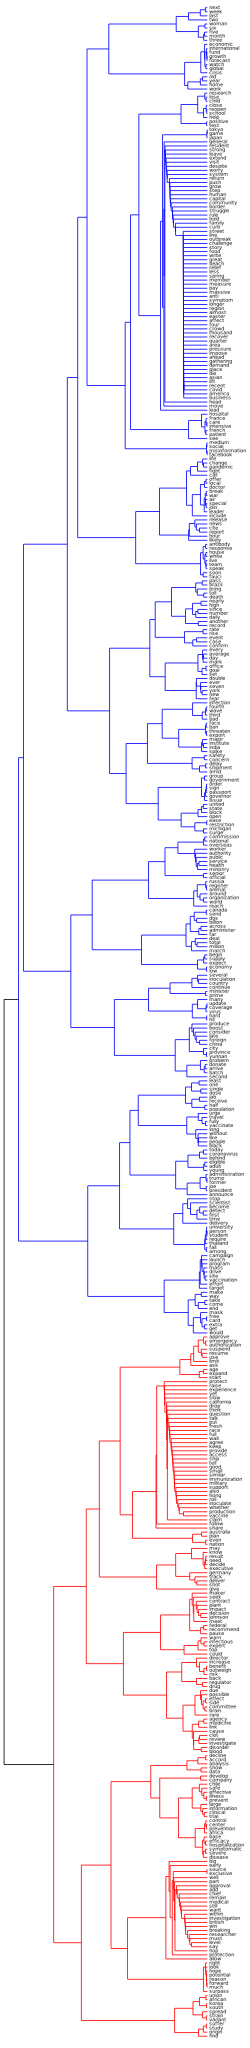

In [ ]:
names = list(G.nodes)
image = svg_dendrogram(dendrogram, names, n_clusters=2, rotate=True,width=500,height=5000,filename='community_dendogram2'+period)
SVG(image)

**Metrics**

In [ ]:
nodelist = list(G.nodes)
labels = list(cut_straight(dendrogram, n_clusters=2, return_dendrogram=False))

community_dend = [[],[]]
i = 0
for node in nodelist:
  community_dend[labels[i]].append(node)
  i += 1

In [ ]:
_ = compute_metrics(G, community_dend)

Coverage:  0.6845593108018555
Performance:  0.46240480961923847
Modularity:  0.12028408143658839


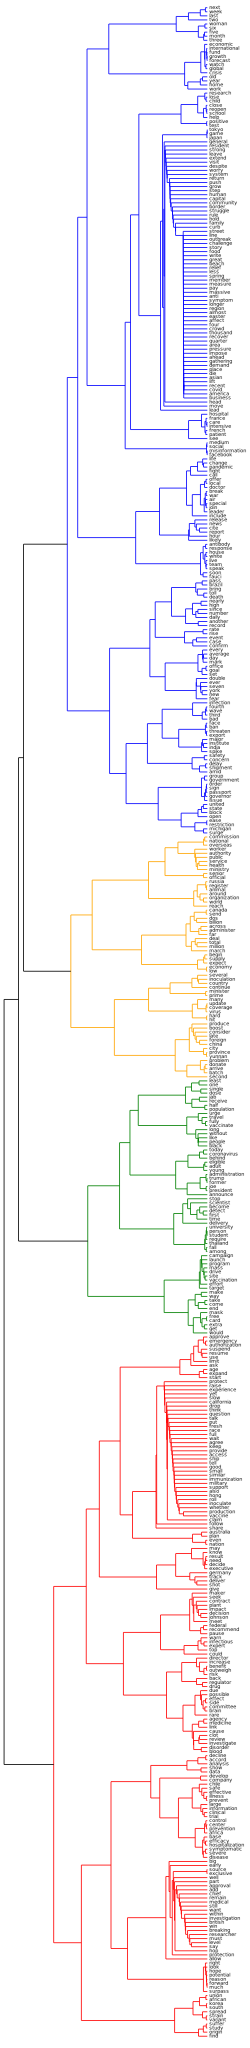

In [ ]:
image = svg_dendrogram(dendrogram, names, n_clusters=4, rotate=True,width=500,height=5000,filename='community_dendogram4'+period)
SVG(image)

**Metrics**

In [ ]:
nodelist = list(G.nodes)
labels = list(cut_straight(dendrogram, n_clusters=4, return_dendrogram=False))

community_dend = [[],[],[],[]]
i = 0
for node in nodelist:
  community_dend[labels[i]].append(node)
  i += 1

In [ ]:
_ = compute_metrics(G, community_dend)

Coverage:  0.5056328694499669
Performance:  0.685186372745491
Modularity:  0.16074707423058626


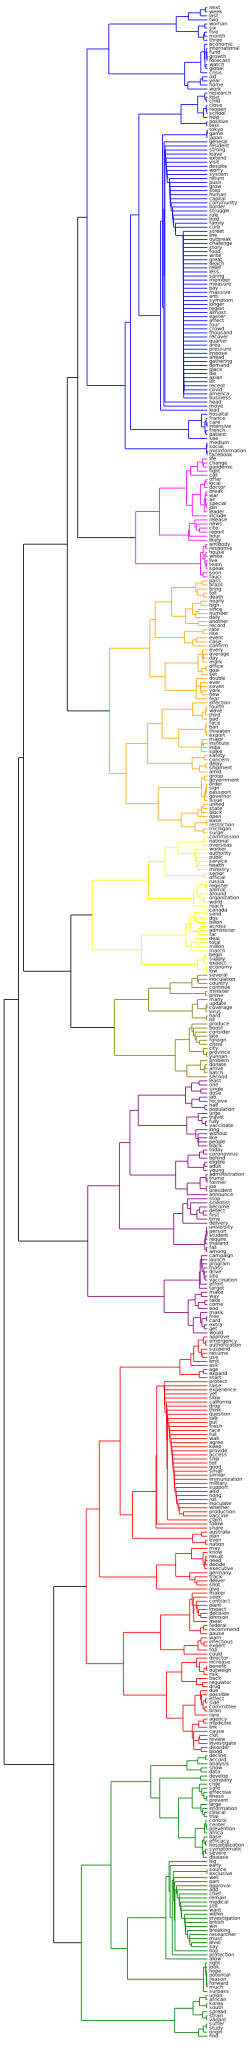

In [ ]:
image = svg_dendrogram(dendrogram, names, n_clusters=8, rotate=True,width=500,height=5000,filename='community_dendogram8'+period)
SVG(image)

**Metrics**

In [ ]:
nodelist = list(G.nodes)
labels = list(cut_straight(dendrogram, n_clusters=8, return_dendrogram=False))

community_dend = [[],[],[],[],[],[],[],[]]
i = 0
for node in nodelist:
  community_dend[labels[i]].append(node)
  i += 1

In [ ]:
_ = compute_metrics(G, community_dend)

Coverage:  0.37773359840954274
Performance:  0.8417795591182364
Modularity:  0.15233192234402027
